MPDATA import

In [1]:
from MPyDATA.arakawa_c.scalar_field import ScalarField
from MPyDATA.arakawa_c.vector_field import VectorField
from MPyDATA.arakawa_c.boundary_condition.cyclic import Cyclic
import numpy as np
import matplotlib.pyplot as plt

Auxiliary functions import

           

In [2]:
from aux_one_dim import grad, extrapolate_in_time, interpolate_in_space

Advectee and advector initialization

In [3]:
dx = 2.4
dt = 0.1

from MPyDATA.options import Options
options = Options(n_iters=2, infinite_gauge=True, flux_corrected_transport=True)

nx = 40

#initial state of liquid
initial_m_value = 0.2
h_initial = np.full(nx, initial_m_value)


#modification of liquid

h_initial[8:20] = np.array([0.8 - (0.02 * i)  for i in range(12)])

h_old = np.array(h_initial)
h_new = np.array(h_initial)

uh_new = np.zeros(nx)
uh_old = np.zeros(nx)

# TODO: to nie jest u, tylko Courant number C=u*dt/dx
u_initial = np.zeros((nx + 1))

u_old = np.array(u_initial)
u_new = np.array(u_initial)

rhs_old = np.array(h_old)

halo = options.n_halo

advectee = ScalarField(
    data = h_new,
    halo=halo, 
    boundary_conditions=(Cyclic(), )
)

advector = VectorField(
    data = (u_initial,),
    halo=halo,
    boundary_conditions=(Cyclic(), )   
)

print('h_new', h_new,'\n')
print('u_new', u_initial,'\n')
print('grad', grad(h_new),'\n')

h_new [0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.8  0.78 0.76 0.74 0.72 0.7
 0.68 0.66 0.64 0.62 0.6  0.58 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2
 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2 ] 

u_new [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 

grad [ 0.    0.    0.    0.    0.    0.    0.    0.3   0.29 -0.02 -0.02 -0.02
 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.2  -0.19  0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.  ] 



Stepper setup

In [4]:
from MPyDATA.stepper import Stepper
stepper = Stepper(options=options, grid=(nx,))

from MPyDATA.solver import Solver
solver = Solver(stepper=stepper, advectee=advectee, advector=advector)

Initial state

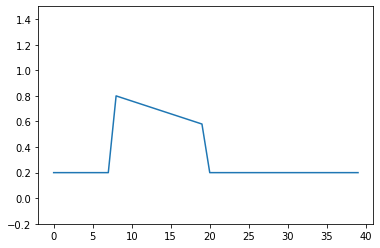

In [5]:
# plt.imshow(h_new, cmap='hot', interpolation='nearest')
axes = plt.gca()
plt.ylim(-.2, 1.5)

# plt.step([i for i in range(nx)], h_new, '-')
plt.plot(h_new, '-')
plt.show()

Main loop

In [6]:
def MPDATA(advector, advectee):
    solver.curr.get()[:] = advectee
    solver.GC_phys.get_component(0)[:] = advector
    solver.advance(nt=1)
    return solver.curr.get() 

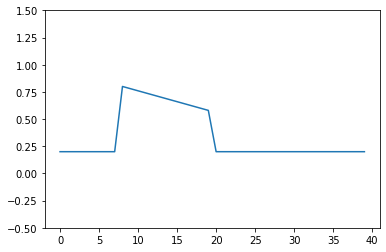

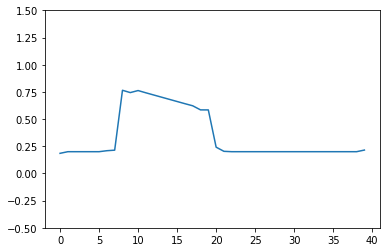

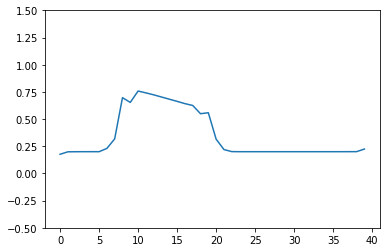

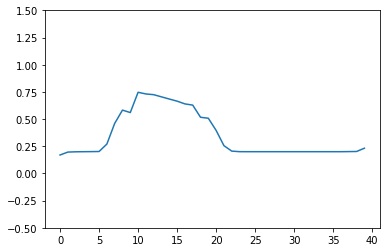

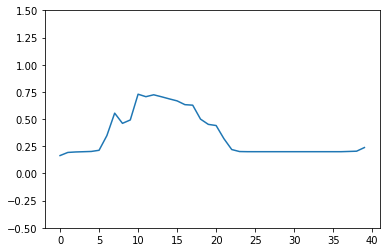

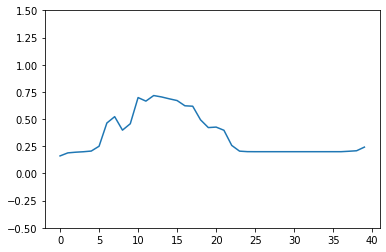

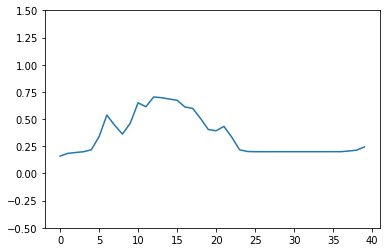

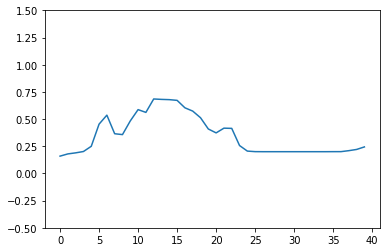

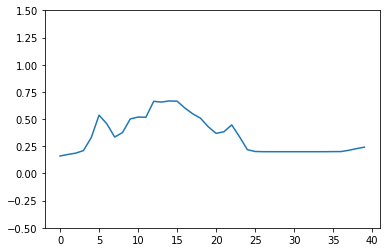

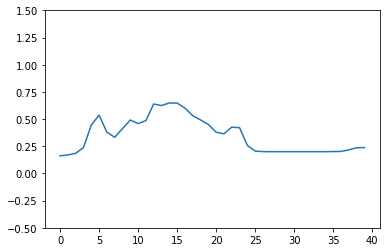

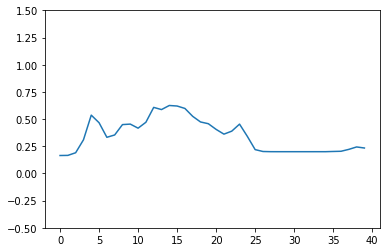

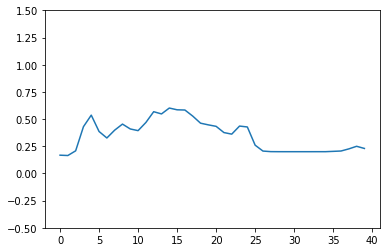

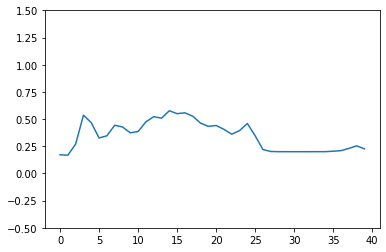

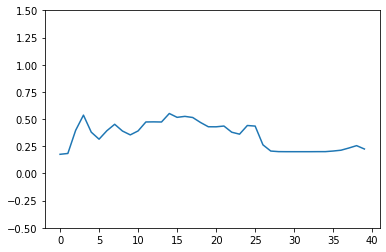

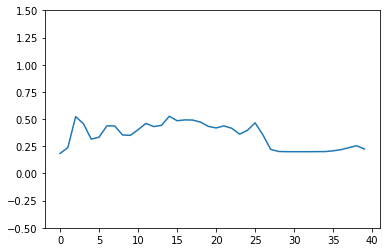

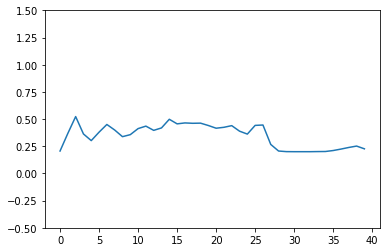

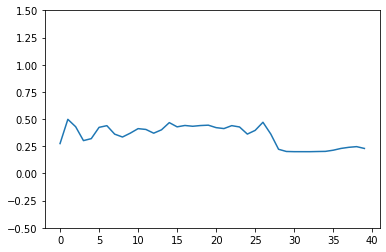

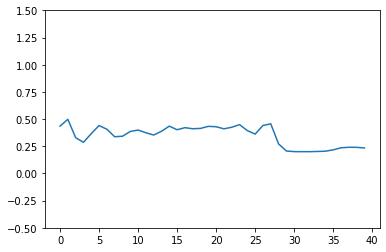

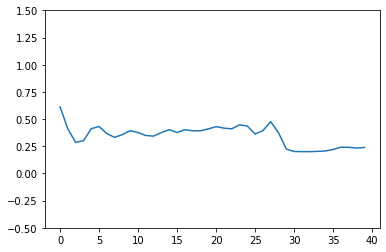

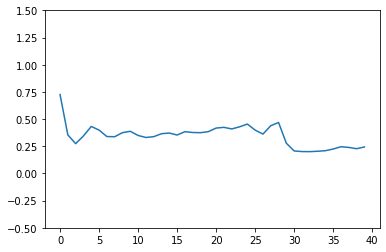

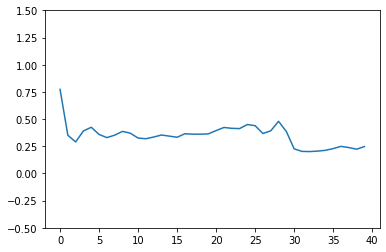

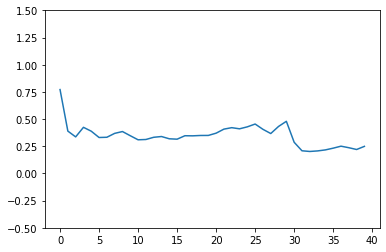

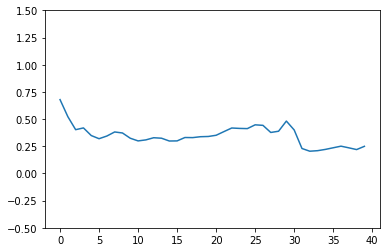

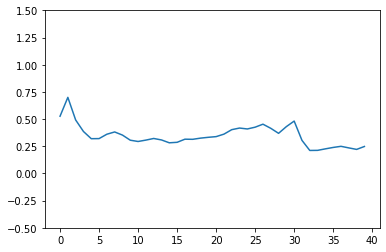

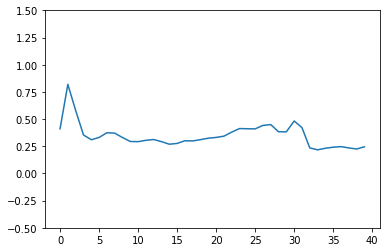

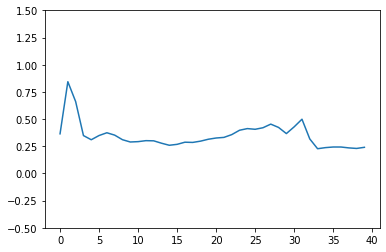

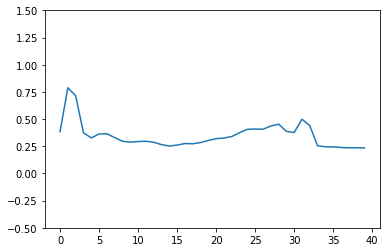

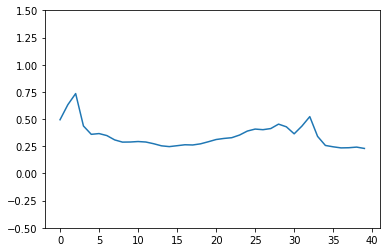

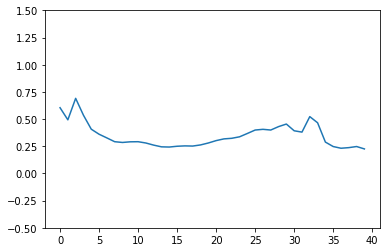

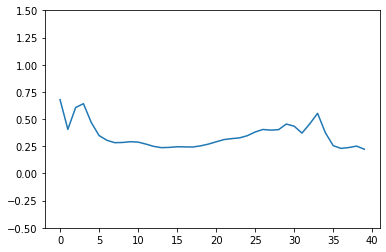

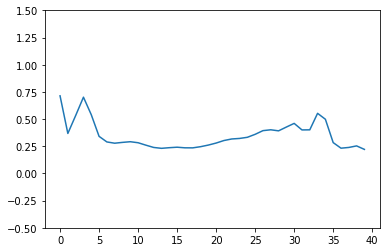

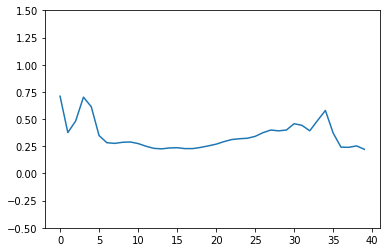

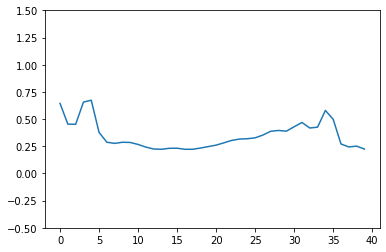

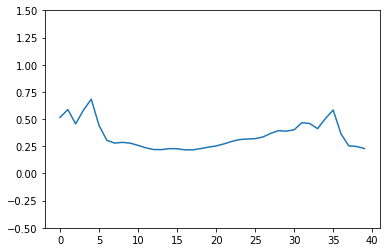

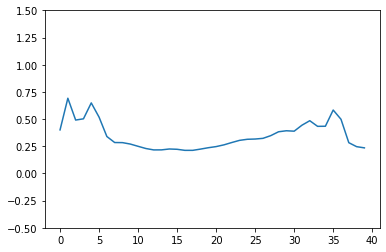

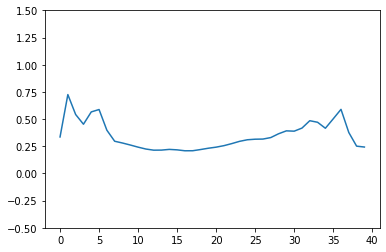

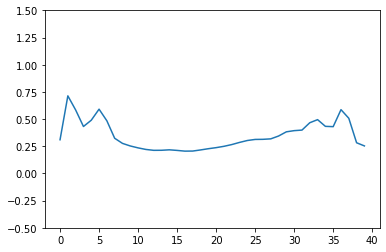

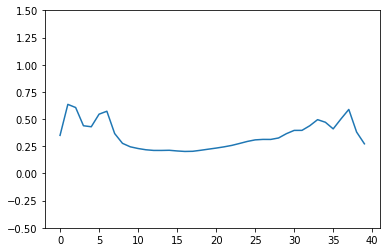

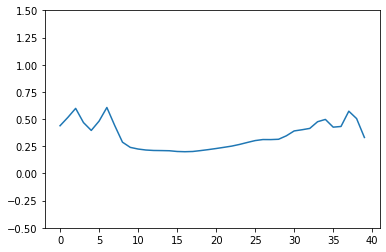

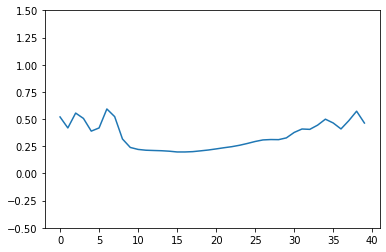

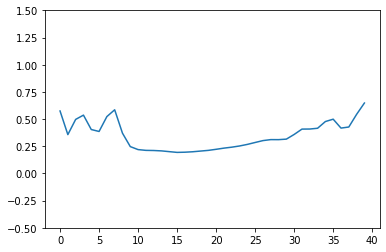

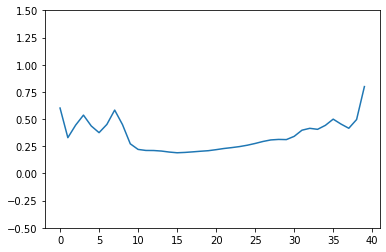

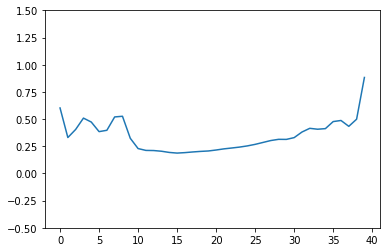

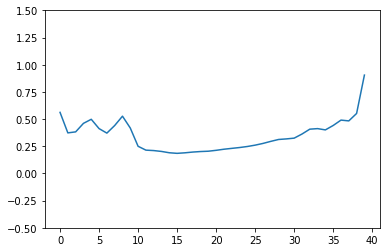

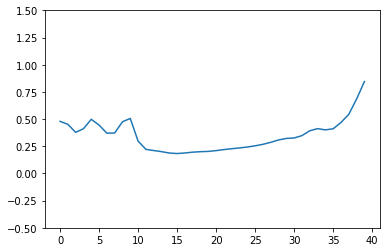

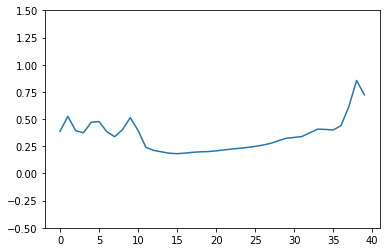

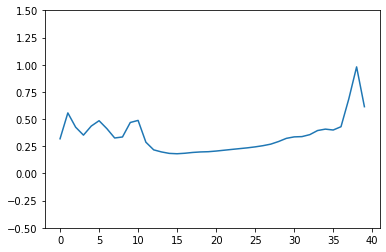

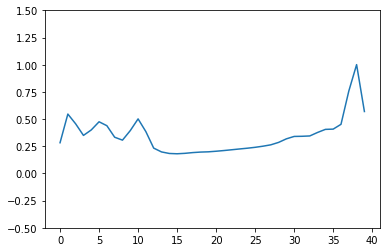

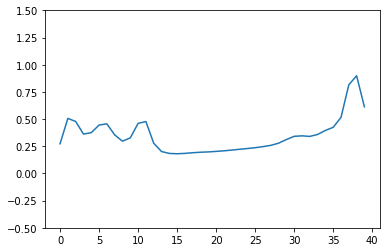

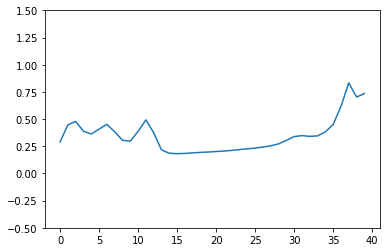

<Figure size 432x288 with 0 Axes>

In [7]:
g = 9.8 # m/s^2
for i in range(50):
    u_mid = extrapolate_in_time(interpolate_in_space(uh_new, h_new), interpolate_in_space(uh_old, h_old))
    
    #RHS = 0, mass conservation
    h_new[:] = MPDATA(u_mid, h_old)
    
    # -h * grad(h)   
    rhs_new = -g *  h_new * grad(h_new, dx=dx)

    #momentum conservation
    uh_new[:] = MPDATA(u_mid, uh_old + .5 * dt * rhs_old) + .5 * dt * rhs_new
    

    plt.ylim(-.5, 1.5)
    plt.plot(h_new, '-')
    plt.show()
#     plt.savefig(str(i) + '.png')
    plt.savefig(str(i) + '.png', format="png")
    
    # replace variables
    h_old, h_new = h_new, h_old
    u_old, u_new = u_new, u_old
    rhs_old, rhs_new = rhs_new, rhs_old
    uh_old, uh_new = uh_new, uh_old

    